In [1]:
import pandas as pd
import ast
import re
import pickle
import logging
import sys
import tiktoken
sys.path.append("utils")

import sqlite_utils
import explore_cwe

In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

langs = ["PHP", "C", "JavaScript", "Python", "Java", "TypeScript", "C++", "Go", "Ruby"]
remove_cwe = ['NVD-CWE-noinfo', 'NVD-CWE-Other']
chosen_cwes = ['CWE-20', 'CWE-287', 'CWE-400', 'CWE-668', 'CWE-74']

conn = sqlite_utils.create_connection('/home/keisuke/code/llm-code-vuln/dataset/CVEfixes_v1.0.8/Data/DB.db')


def pre_processing(df):
    print(f"Initial df length: {len(df)}")

    # keep only the specified programming languages
    df = df[df['programming_language'].isin(langs)]
    print(f"After filtering programming languages: {len(df)}")

    # code diff: both add & del should exist
    df['diff_added'] = df.apply(lambda row: ast.literal_eval(row.diff_parsed)['added'], axis=1)
    df['diff_deleted'] = df.apply(lambda row: ast.literal_eval(row.diff_parsed)['deleted'], axis=1)
    df = df[df['diff_added'].apply(bool) & df['diff_deleted'].apply(bool)]
    print(f"After filtering diff_added & diff_deleted: {len(df)}")

    df = df.reset_index(drop=True)
    df = df.drop(columns=['diff_parsed'])

    # cve description type str -> arr
    def parse_py_literal(text):
        if not isinstance(text, str):
            return text
        try:
            return ast.literal_eval(text)
        except (SyntaxError, ValueError):
            return None

    df['cve_description'] = df['cve_description'].apply(parse_py_literal)

    # code before and after
    df = df[df['vuln_code'].notna()]
    print(f"After removing NaN vuln_code: {len(df)}")

    df = df[df['vuln_code'] != 'None']
    print(f"After removing 'None' vuln_code: {len(df)}")

    df = df[df['non_vuln_code'].notna()]
    print(f"After removing NaN non_vuln_code: {len(df)}")

    df = df[df['non_vuln_code'] != 'None']
    print(f"After removing 'None' non_vuln_code: {len(df)}")

    # remove rows where number of lines in the code is below 30
    for col in ['vuln_code', 'non_vuln_code']:
        df[f'{col}_num_lines'] = df[col].apply(
            lambda x: x.count('\n') + 1 if isinstance(x, str) else 0
        )
    df = df[df['vuln_code_num_lines'] >= 30]
    print(f"After filtering vuln_code with >=30 lines: {len(df)}")

    df = df[df['non_vuln_code_num_lines'] >= 30]
    print(f"After filtering non_vuln_code with >=30 lines: {len(df)}")

    # remove empty list in diff_deleted
    df = df[df['diff_deleted'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
    print(f"After removing empty lists in diff_deleted: {len(df)}")

    # token_count should be num
    df['token_count'] = df['token_count'].apply(parse_py_literal)
    df = df.dropna(subset=['token_count'])
    df['token_count'] = pd.to_numeric(df['token_count'])

    # Function to recalculate token count
    def recalculate_token_count(text):
        encoding = tiktoken.get_encoding("cl100k_base")
        return len(encoding.encode(text, disallowed_special=())) if text else 0
    df["token_count"] = df["vuln_code"].apply(recalculate_token_count)
    
    print(f"After processing token_count: {len(df)}")

    df['complexity'] = df['complexity'].apply(parse_py_literal)
    df = df.dropna(subset=['complexity'])
    df['complexity'] = pd.to_numeric(df['complexity'])

    # drop the other CWEs
    df = df[~df["cwe_id"].isin(remove_cwe)]
    print(f"After removing specific CWEs: {len(df)}")

    # Add Cluss column (Parent CWE)
    cwe_uniques = df['cwe_id'].unique()
    for cwe in cwe_uniques:
        parents = explore_cwe.find_parents_dict(cwe.split('-')[1])
        if parents is None or len(parents['Class']) == 0:
            continue
        df.loc[df['cwe_id'] == cwe, 'class'] = parents['Class'][-1]

    df = df.dropna()
    print(f"Final df length after dropna: {len(df)}")

    return df

In [3]:
query = f"""
SELECT
        file_change.file_change_id,
        file_change.programming_language,
        cwe.cwe_id,
        cwe.cwe_name,
        file_change.code_after AS non_vuln_code,
        file_change.code_before AS vuln_code,
        file_change.complexity,
        cwe.description AS cwe_description,
        file_change.diff_parsed,
        cve.description AS cve_description,
        file_change.token_count
FROM file_change
        INNER JOIN fixes
                ON file_change.hash = fixes.hash
        INNER JOIN cve
                ON fixes.cve_id = cve.cve_id
        INNER JOIN cwe_classification
                ON cve.cve_id = cwe_classification.cve_id
        INNER JOIN cwe
                ON cwe_classification.cwe_id = cwe.cwe_id
WHERE
        file_change.programming_language IS NOT NULL
        AND cwe.cwe_id IS NOT NULL
        AND cwe.cwe_name IS NOT NULL
        AND file_change.code_before IS NOT NULL
        AND cwe.description IS NOT NULL
        AND file_change.diff_parsed IS NOT NULL
        AND cve.description IS NOT NULL
        AND file_change.token_count IS NOT NULL;
    """
logger.info('Executing SQL query to fetch data')
df = pd.read_sql(query, con=conn)
print(len(df))
logger.info('Data fetched successfully, starting preprocessing')
df = pre_processing(df)
print(len(df))

INFO:__main__:Executing SQL query to fetch data
INFO:__main__:Data fetched successfully, starting preprocessing


62692
Initial df length: 62692
After filtering programming languages: 45356


/tmp/ipykernel_3156322/2130652231.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_added'] = df.apply(lambda row: ast.literal_eval(row.diff_parsed)['added'], axis=1)
/tmp/ipykernel_3156322/2130652231.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_deleted'] = df.apply(lambda row: ast.literal_eval(row.diff_parsed)['deleted'], axis=1)


After filtering diff_added & diff_deleted: 27274
After removing NaN vuln_code: 27274
After removing 'None' vuln_code: 27274
After removing NaN non_vuln_code: 27274
After removing 'None' non_vuln_code: 27274
After filtering vuln_code with >=30 lines: 25812
After filtering non_vuln_code with >=30 lines: 25757
After removing empty lists in diff_deleted: 25757
After processing token_count: 23869
After removing specific CWEs: 21200
Final df length after dropna: 19884
19884


In [28]:
def pick_samples(df):
    sample_size = 10
    vuln_selected = []
    non_vuln_selected = []
    max_token_size = 5500
    max_comp = 100
    
    for lang in langs:
            # Vuln samples
            for cwe in chosen_cwes:
                    filtered = df[
                            (df['programming_language'] == lang) &
                            (df['class'] == cwe) &
                            (df['token_count'] <= max_token_size) &
                            (df['complexity'] <= max_comp)
                    ]
                    total_available = len(filtered)
                    count = 0
    
                    if len(filtered) == 0:
                            logger.info('! %s %s No samples available', lang, cwe)
                            samples = None  # Indicate there's no data
                    elif len(filtered) < sample_size:
                            logger.info('- %s %s %d Not enough samples', lang, cwe, len(filtered))
                            samples = filtered  # Use all available samples
                            count = len(filtered)
                    else:
                            # logger.info('+ %s %s %d', lang, cwe, len(filtered))
                            samples = filtered.sample(n=sample_size, random_state=123)
                            count = len(samples)
    
                    if samples is not None:
                            df = df.drop(samples.index)
                            vuln_selected.append(samples)
    
                    percentage_used = (count / total_available) * 100 if total_available > 0 else 0
                    logger.info('%s:%s: %d/%d (%.2f%%)', lang, cwe, count, total_available, percentage_used)
            
            # Non-vuln samples
            filtered = df[
                            (df['programming_language'] == lang) &
                            (df['token_count'] <= max_token_size) &
                            (df['complexity'] <= max_comp)
            ]
            samples = filtered.sample(n=sample_size, random_state=123)
            non_vuln_selected.append(samples)
            df = df.drop(samples.index)
    
    # Combine all selected samples into one DataFrame
    final_vuln_samples = pd.concat(vuln_selected, ignore_index=True) if vuln_selected else pd.DataFrame()
    final_non_vuln_samples = pd.concat(non_vuln_selected, ignore_index=True) if non_vuln_selected else pd.DataFrame()
    
    # Display final sampled DataFrame
    logger.info('final vuln sample size: %d', len(final_vuln_samples))
    logger.info('final non-vulns sample size: %d', len(final_non_vuln_samples))
    
    return final_vuln_samples, final_non_vuln_samples, df

In [29]:
logger.info('Preprocessing completed, starting sample selection')
vuln, non_vuln, final_df = pick_samples(df)
print(len(final_df))
print(len(vuln))
print(len(non_vuln))

INFO:__main__:Preprocessing completed, starting sample selection
INFO:__main__:PHP:CWE-20: 10/233 (4.29%)
INFO:__main__:PHP:CWE-287: 10/73 (13.70%)
INFO:__main__:PHP:CWE-400: 10/33 (30.30%)
INFO:__main__:PHP:CWE-668: 10/360 (2.78%)
INFO:__main__:PHP:CWE-74: 10/2623 (0.38%)
INFO:__main__:C:CWE-20: 10/965 (1.04%)
INFO:__main__:C:CWE-287: 10/21 (47.62%)
INFO:__main__:C:CWE-400: 10/33 (30.30%)
INFO:__main__:C:CWE-668: 10/54 (18.52%)
INFO:__main__:C:CWE-74: 10/19 (52.63%)
INFO:__main__:JavaScript:CWE-20: 10/51 (19.61%)
INFO:__main__:JavaScript:CWE-287: 10/16 (62.50%)
INFO:__main__:JavaScript:CWE-400: 10/58 (17.24%)
INFO:__main__:JavaScript:CWE-668: 10/62 (16.13%)
INFO:__main__:JavaScript:CWE-74: 10/577 (1.73%)
INFO:__main__:Python:CWE-20: 10/77 (12.99%)
INFO:__main__:Python:CWE-287: 10/58 (17.24%)
INFO:__main__:Python:CWE-400: 10/77 (12.99%)
INFO:__main__:Python:CWE-668: 10/135 (7.41%)
INFO:__main__:Python:CWE-74: 10/176 (5.68%)
INFO:__main__:Java:CWE-20: 10/36 (27.78%)
INFO:__main__:Java:C

19344
450
90


In [34]:
for f_name, data in zip(['test_vuln', 'test_non_vuln', 'df'], [vuln, non_vuln, final_df]):
    with open(f'./dataset/new_test/{f_name}.pkl', 'wb') as f:
        pickle.dump(data, f)
        logger.info('Data saved to %s.pkl', f_name)

INFO:__main__:Data saved to test_vuln.pkl
INFO:__main__:Data saved to test_non_vuln.pkl
INFO:__main__:Data saved to df.pkl


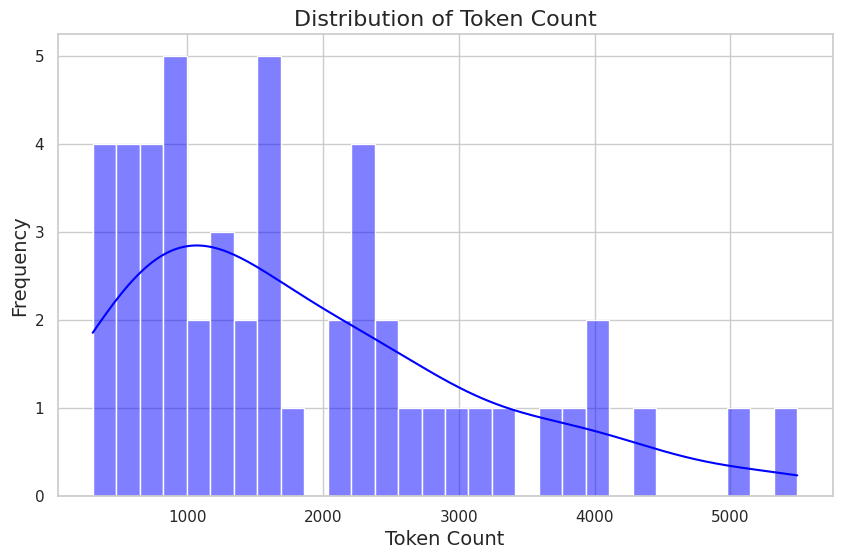

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Create a histogram or kernel density plot
plt.figure(figsize=(10, 6))
sns.histplot(vuln[(vuln['token_count'] < 10000) & (vuln['programming_language'] == 'JavaScript')]['token_count'], kde=True, bins=30, color='blue')

# Add labels and title
plt.title('Distribution of Token Count', fontsize=16)
plt.xlabel('Token Count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()

In [33]:
import random

index = random.randint(0, 100)

print(vuln['token_count'].iloc[index])
print(vuln['cve_description'].iloc[index])
print(vuln['class'].iloc[index])
print(vuln['vuln_code'].iloc[index])


2725
[{'lang': 'en', 'value': 'WeBid version up to current version 1.2.2 contains a Directory Traversal vulnerability in getthumb.php that can result in Arbitrary Image File Read. This attack appear to be exploitable via HTTP GET Request. This vulnerability appears to have been fixed in after commit 256a5f9d3eafbc477dcf77c7682446cc4b449c7f.'}]
CWE-668
<?php
/***************************************************************************
 *   copyright				: (C) 2008 - 2017 WeBid
 *   site					: http://www.webidsupport.com/
 ***************************************************************************/

/***************************************************************************
 *   This program is free software; you can redistribute it and/or modify
 *   it under the terms of the GNU General Public License as published by
 *   the Free Software Foundation; either version 2 of the License, or
 *   (at your option) any later version. Although none of the code may be
 *   sold. If you have been